<a href="https://colab.research.google.com/github/jakhin03/PROJECT_ASnED_HUST/blob/main/src/pynote/ANOMALY_NETWORK_TRAFFIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT - ANORMARL NETWORK TRAFFIC DETECTION 

## Goals:
  * Detecting abcxyz

## Folder structure:
```
.
├── Datasets
│   └── ...
├── Figure
│   └── ...
├── README.md
├── requirements.txt
└── src
    ├── app.py
    └── pynote
        └── ANOMALY_NETWORK_TRAFFIC.ipynb
```


## Usage:

In [ ]:
!git clone "https://github.com/jakhin03/PROJECT_ASnED_HUST"

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd PROJECT_ASnED_HUST/src/pynote

## 1. Import module and library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

## 2. Preprocessing and data exploration:



### a. Datasets can find on: [source](https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup99.html)

In [ ]:
data = pd.read_csv("../../Datasets/network_data.csv")
print(data.shape)
print(data.columns)
data.head()
print('Number of days for which data is available {:d}'.format(data['date'].nunique()))
print('Unique local ip {:d}'.format(data['l_ipn'].nunique()))
print('Unique remote ASN {:d}'.format(data['r_asn'].nunique()))
print('Minimum flow count per day {:d}'.format(data['f'].min()))
print('Maximum flow count per day {:d}'.format(data['f'].max()))
print(data.head())



(20803, 4)
Index(['date', 'l_ipn', 'r_asn', 'f'], dtype='object')
Number of days for which data is available 92
Unique local ip 10
Unique remote ASN 2005
Minimum flow count per day 1
Maximum flow count per day 784234
         date  l_ipn  r_asn  f
0  2006-07-01      0    701  1
1  2006-07-01      0    714  1
2  2006-07-01      0   1239  1
3  2006-07-01      0   1680  1
4  2006-07-01      0   2514  1


### b. Exploring datasets:
* Create dataframe for visualization

In [ ]:
dic = {'2006-08-24':1,'2006-09-04':5,'2006-09-18':4,'2006-09-26':3,'2006-09-26':6}
marked_anomalies = pd.DataFrame.from_dict(dic,orient='index')
marked_anomalies.reset_index(inplace = True)
marked_anomalies.columns = ['date','l_ipn']
print(marked_anomalies)

         date  l_ipn
0  2006-08-24      1
1  2006-09-04      5
2  2006-09-18      4
3  2006-09-26      6


* Aggregating daily connections

In [ ]:
daily_aggregate = data.groupby(['date'])[['f']].sum()
daily_aggregate.reset_index(inplace = True)
daily_aggregate[['f']].describe()

,f
count,92.000000
mean,21235.847826
std,85752.692609
min,2706.000000
25%,5211.750000
50%,8773.500000
75%,12426.000000
max,788297.000000


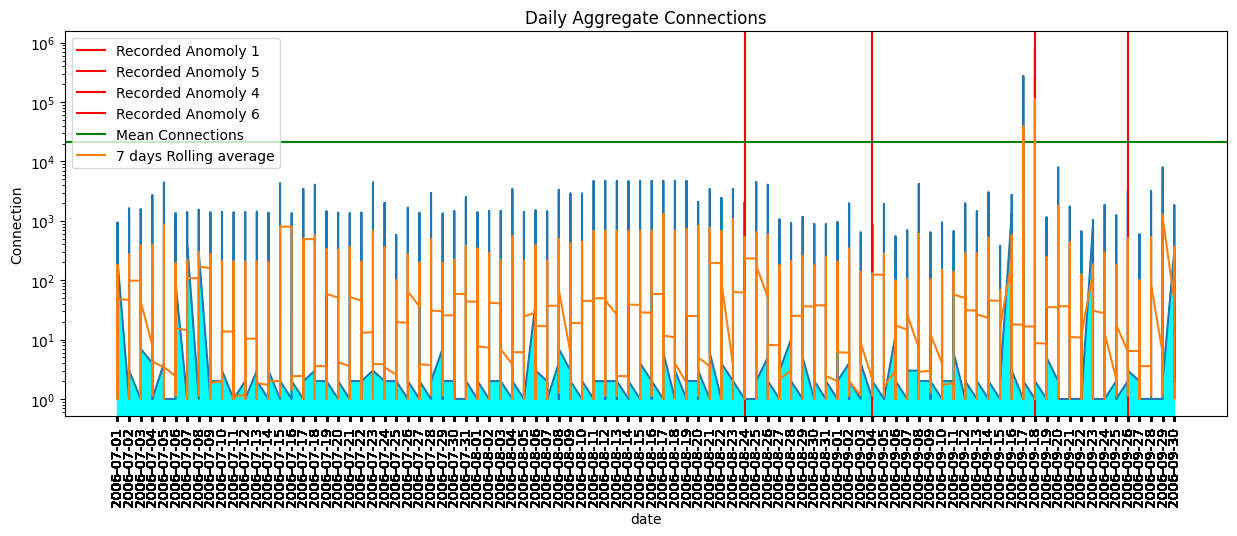

In [ ]:
daily_mean = round(daily_aggregate['f'].mean(),2)
plt.figure(figsize=(15,5))
plt.plot(data['date'],data['f'])
[plt.axvline(x=_x, color='r' , label = 'Recorded Anomoly {}'.format(ip)) for _x,ip in list(marked_anomalies[['date','l_ipn']].to_records(index=False))]
plt.axhline(y= daily_mean, color='g', label = 'Mean Connections')
plt.plot(data['date'],data['f'].rolling(7).mean(), label = '7 days Rolling average')
plt.xticks(data['date'][::2],  rotation='vertical')
plt.yscale('log')
plt.xlabel('date')
plt.ylabel('Connection')
plt.title('Daily Aggregate Connections')
plt.fill_between(data['date'],data['f'],color='aqua')
plt.legend()
plt.show() 

In [ ]:
daily_aggregate_l_ipn = data.groupby(['l_ipn','date'])[['f']].sum()
daily_aggregate_l_ipn.reset_index(inplace= True)

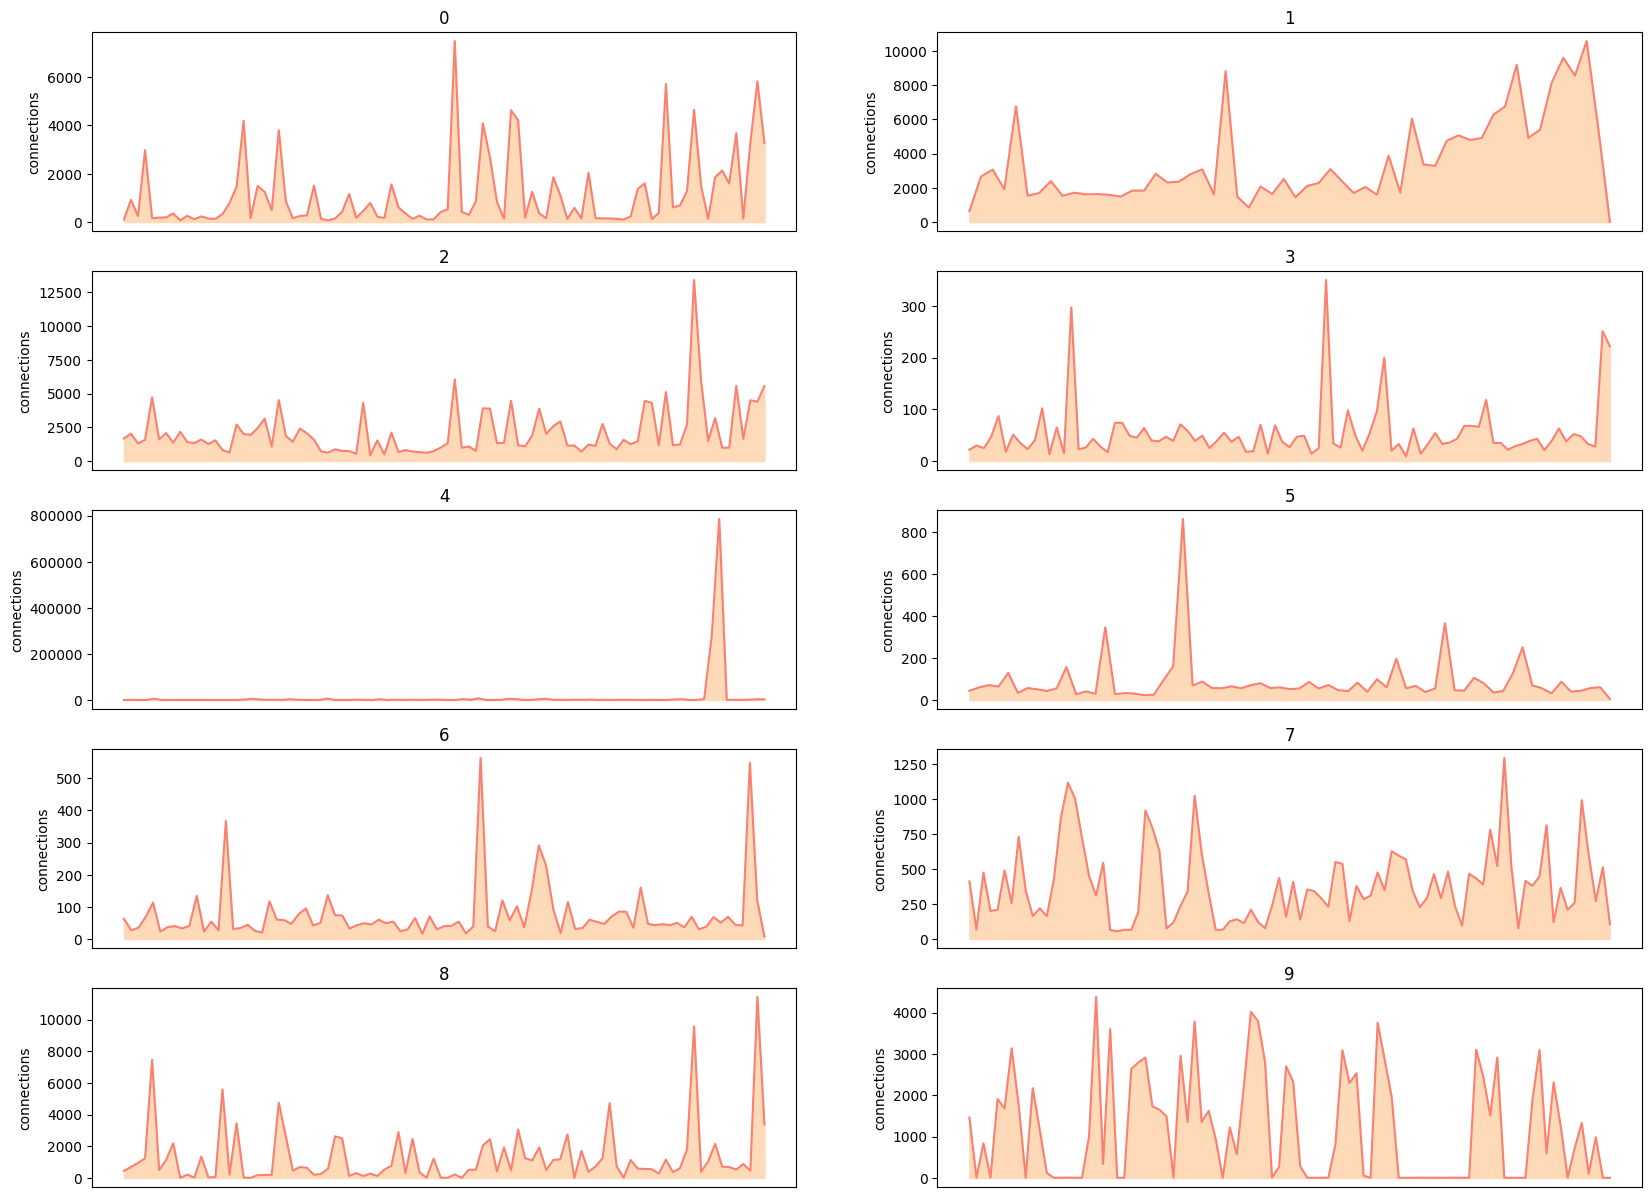

In [ ]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))

plot_row = 0
plot_col = 0

for i in range(data['l_ipn'].nunique()):
    temp = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == i]
    axes[plot_row,plot_col].set_title(i)
    axes[plot_row,plot_col].set_xlabel('date')
    axes[plot_row,plot_col].set_ylabel('connections')
    
    axes[plot_row,plot_col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    axes[plot_row,plot_col].plot(temp['date'],temp['f'], color = 'salmon')
    axes[plot_row,plot_col].get_xaxis().set_visible(False)
    axes[plot_row,plot_col].fill_between(temp['date'],temp['f'], color='peachpuff')
    

    plot_col = plot_col + 1
    if(plot_col == 2):
        plot_row = plot_row + 1
        plot_col = 0
plt.show()

* Aggregating flows on per r_asn

In [ ]:
daily_aggregate_r_asn = data.groupby(['r_asn'])[['f']].sum()
daily_aggregate_r_asn.reset_index(inplace = True)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
daily_aggregate_r_asn['f'].describe()

count      2005.00
mean        974.41
std       23862.63
min           1.00
25%           2.00
50%           8.00
75%          43.00
max     1059254.00
Name: f, dtype: float64

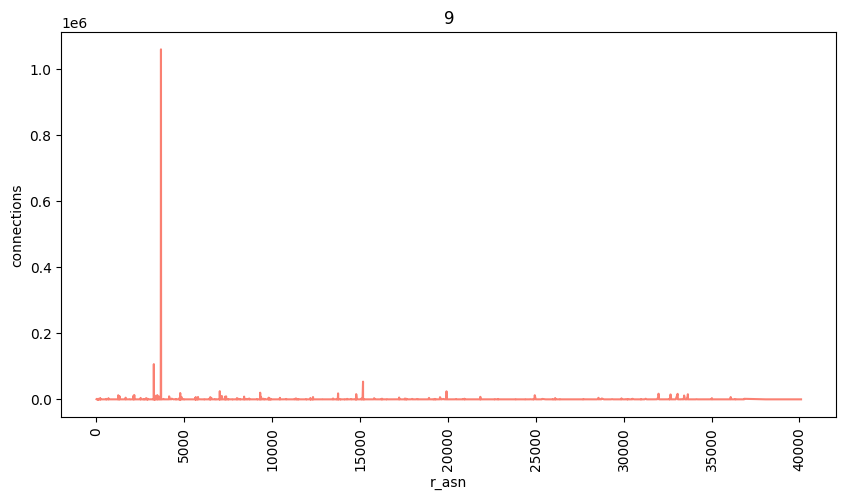

In [ ]:
plt.figure(figsize=(10,5))
plt.title(i)
plt.xlabel('r_asn')
plt.ylabel('connections')
plt.xticks(rotation='vertical')
#n_bins =  daily_aggregate_r_asn['r_asn']
#plt.hist(daily_aggregate_r_asn['f'], n_bins, histtype ='bar')
plt.plot(daily_aggregate_r_asn['r_asn'],daily_aggregate_r_asn['f'], color = 'salmon')
plt.show()

## 3. Anomaly detection
*Anomalies are marked in red dot in graph*

### a. Using prophet library

In [ ]:
!pip install prophet

In [ ]:
from pandas import to_datetime
from prophet import Prophet

In [ ]:
def get_daily_aggregate_l_ipn(in_l_ipn):
    temp_data = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_data.columns = ['ds','y']
    temp_data['ds'] = to_datetime(temp_data['ds'])
    temp_data.reset_index(inplace=True,drop=True)
    return temp_data

In [ ]:
def get_forecast(ts,in_l_ipn):
    
    model = Prophet(seasonality_mode='additive',daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True)
    model.fit(ts)
    forecast = model.predict(pd.DataFrame(ts['ds']))
    
    ts['anomaly'] = 0
    p_color = np.full((ts.shape[0],1),'green')
    for i in range(forecast.shape[0]):
        if((forecast.at[i,'yhat_lower'] > ts.at[i,'y']) or (forecast.at[i,'yhat_upper'] < ts.at[i,'y'])):
            ts.at[i,'anomaly'] = 1
            p_color[i] = 'red'
                
    model.plot(forecast)
    
    plt.scatter(ts['ds'],ts['y'],c=p_color.ravel())
    plt.title('Forcast plot for l_ipn %d' %in_l_ipn)
    plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/ky5jdi3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/5m63y24h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28531', 'data', 'file=/tmp/tmpz047zyic/ky5jdi3r.json', 'init=/tmp/tmpz047zyic/5m63y24h.json', 'output', 'file=/tmp/tmpz047zyic/prophet_model8tzc7g88/prophet_model-20230530121154.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


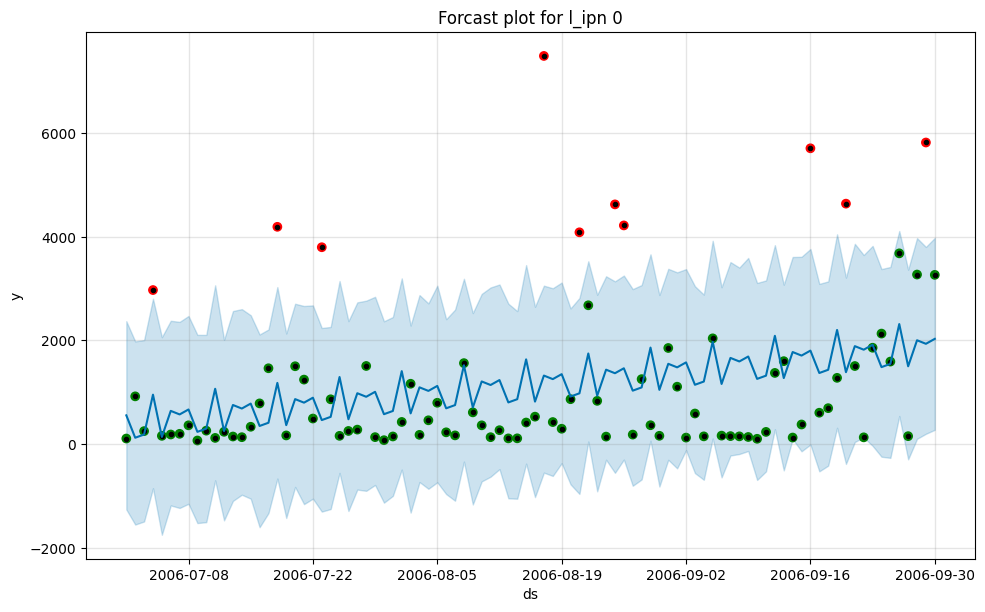

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/vu1imj13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/1k6hhf8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70482', 'data', 'file=/tmp/tmpz047zyic/vu1imj13.json', 'init=/tmp/tmpz047zyic/1k6hhf8z.json', 'output', 'file=/tmp/tmpz047zyic/prophet_model2j7es9je/prophet_model-20230530121156.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


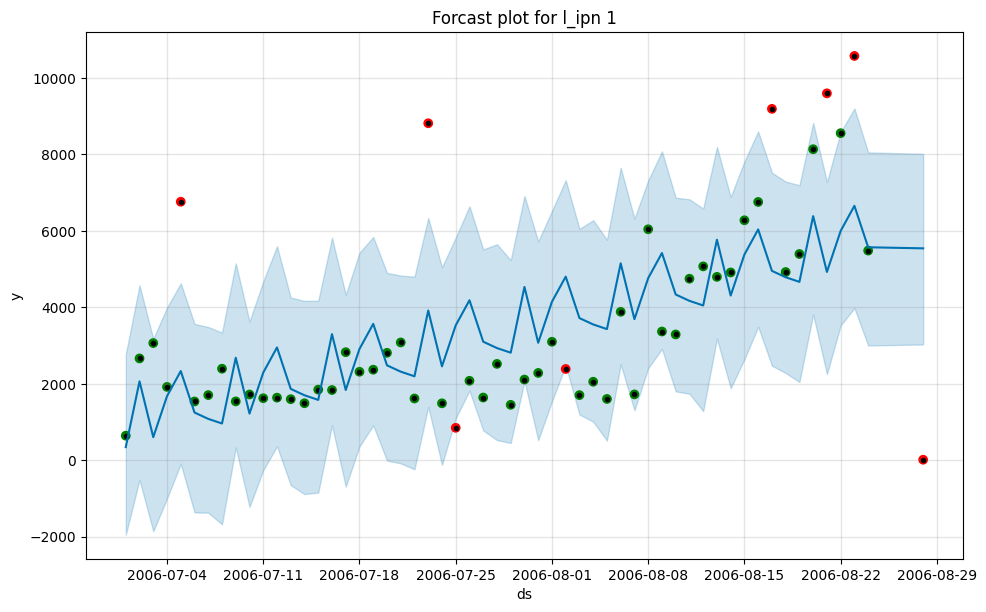

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/tccrpu1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/l1n5vabn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53430', 'data', 'file=/tmp/tmpz047zyic/tccrpu1n.json', 'init=/tmp/tmpz047zyic/l1n5vabn.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelf85tftkb/prophet_model-20230530121158.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


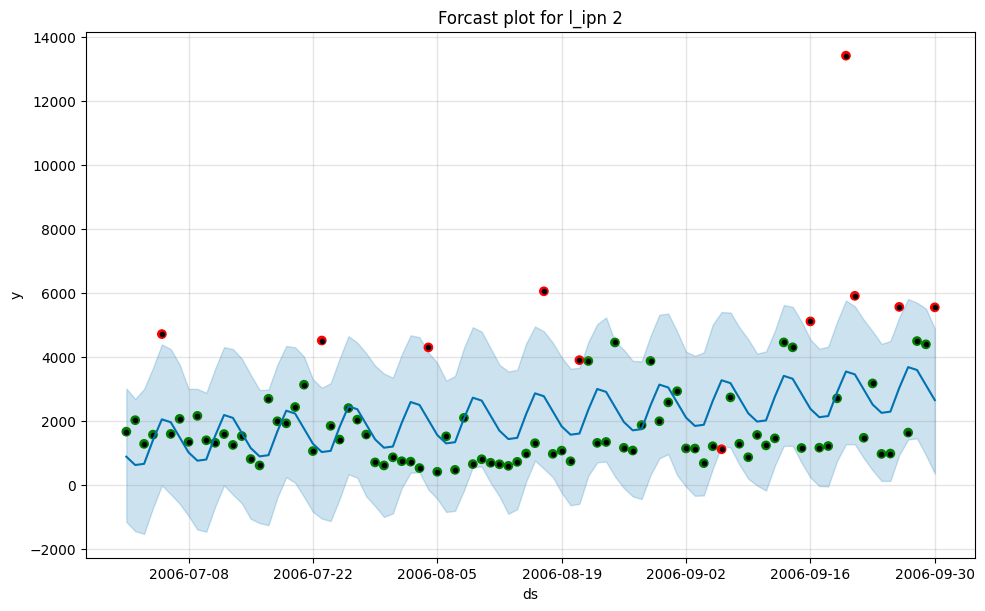

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/lx_fak9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/t448hruf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14145', 'data', 'file=/tmp/tmpz047zyic/lx_fak9w.json', 'init=/tmp/tmpz047zyic/t448hruf.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelg8kwzk9z/prophet_model-20230530121200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


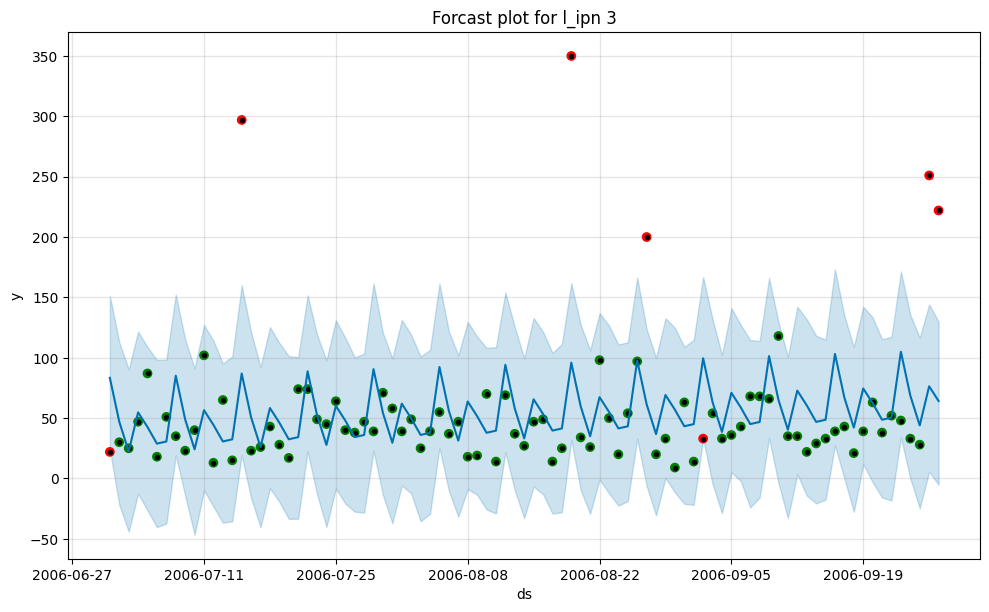

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/32jj5ilx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/ylh7su59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9815', 'data', 'file=/tmp/tmpz047zyic/32jj5ilx.json', 'init=/tmp/tmpz047zyic/ylh7su59.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelblg4gdyb/prophet_model-20230530121201.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


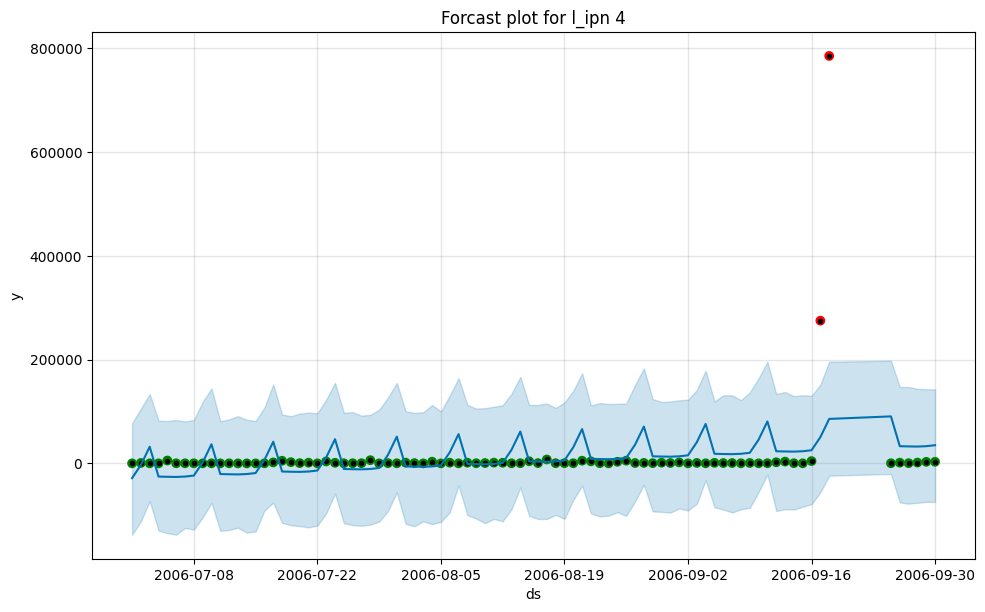

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/yl1ac7jt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/9vn_6g74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31642', 'data', 'file=/tmp/tmpz047zyic/yl1ac7jt.json', 'init=/tmp/tmpz047zyic/9vn_6g74.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelu7tt27n5/prophet_model-20230530121203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


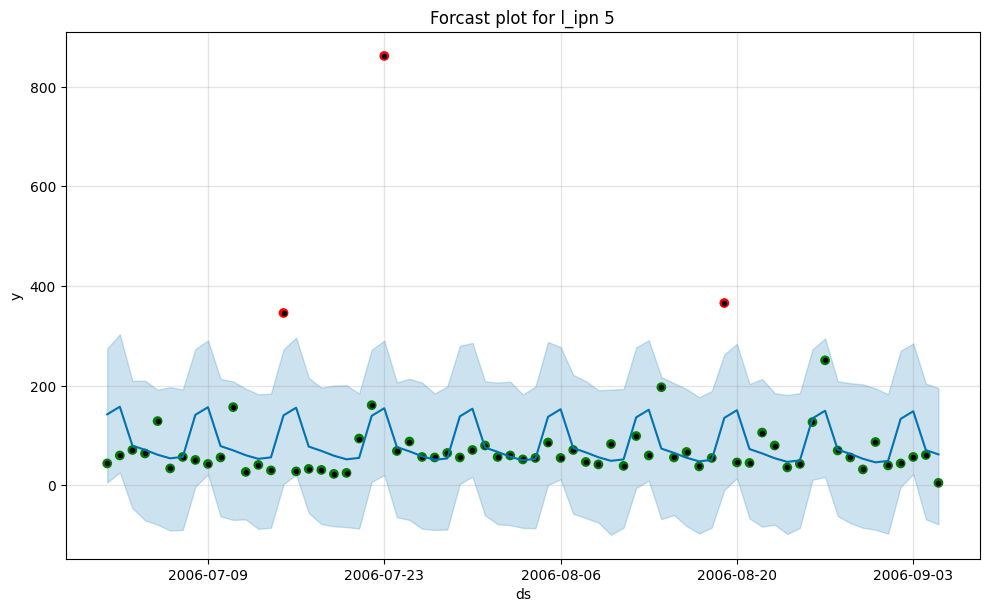

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/8w3f8web.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/kf5sb0ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23925', 'data', 'file=/tmp/tmpz047zyic/8w3f8web.json', 'init=/tmp/tmpz047zyic/kf5sb0ez.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelxlf8ugmu/prophet_model-20230530121205.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


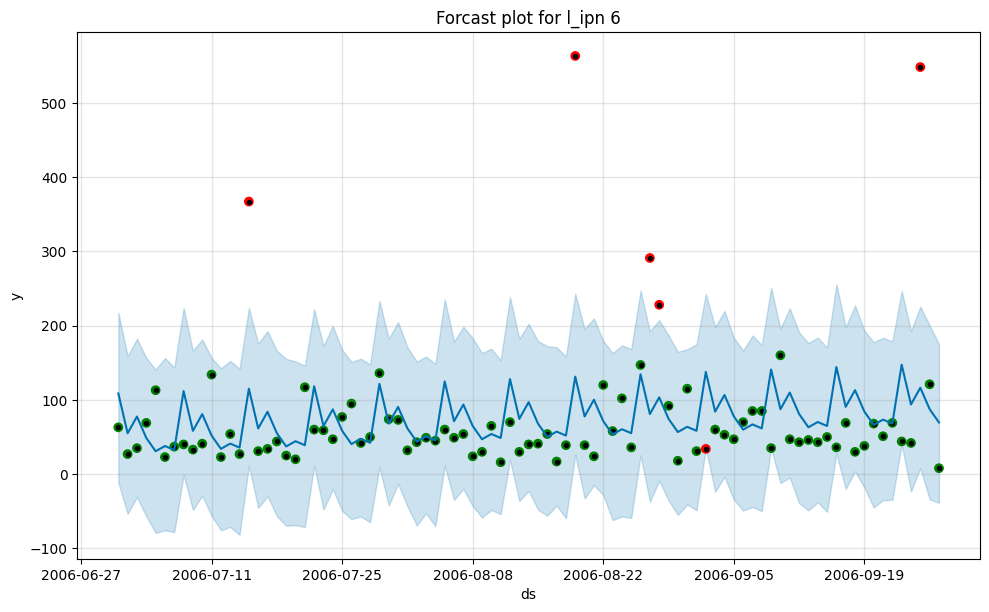

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/l_rxpku4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/9h4b2y6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31450', 'data', 'file=/tmp/tmpz047zyic/l_rxpku4.json', 'init=/tmp/tmpz047zyic/9h4b2y6w.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelya4hzees/prophet_model-20230530121207.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


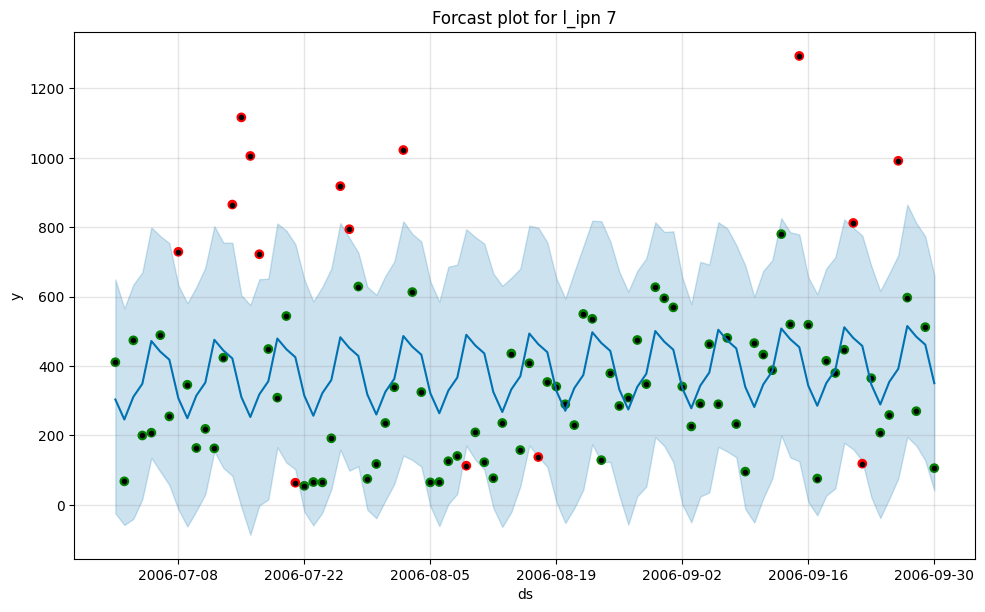

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/8o7erztx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/5xoqm184.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=392', 'data', 'file=/tmp/tmpz047zyic/8o7erztx.json', 'init=/tmp/tmpz047zyic/5xoqm184.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelicdbds_a/prophet_model-20230530121208.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


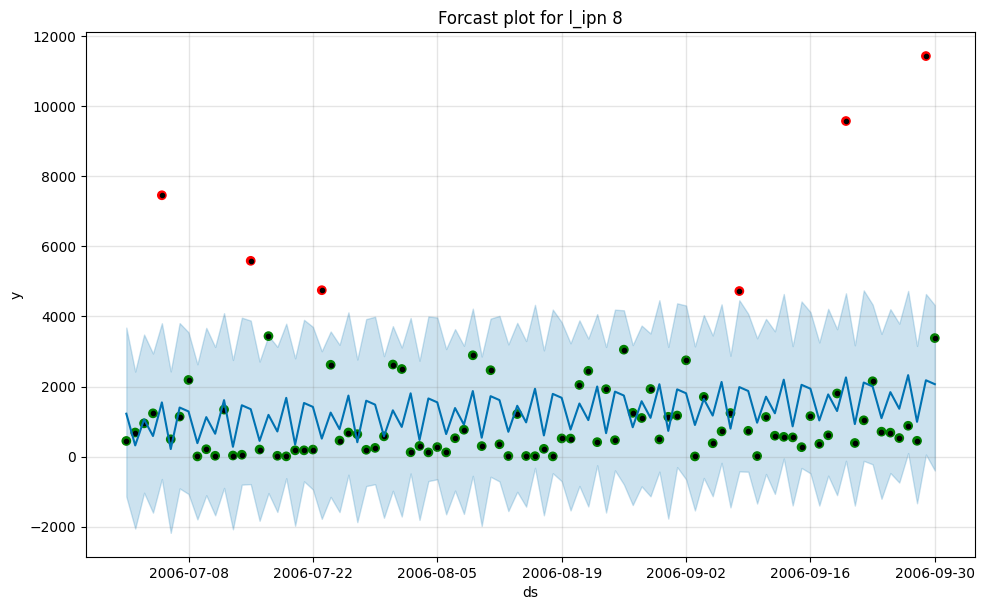

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/koj11mf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz047zyic/mvdiydso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48909', 'data', 'file=/tmp/tmpz047zyic/koj11mf4.json', 'init=/tmp/tmpz047zyic/mvdiydso.json', 'output', 'file=/tmp/tmpz047zyic/prophet_modelns6u486u/prophet_model-20230530121209.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:12:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


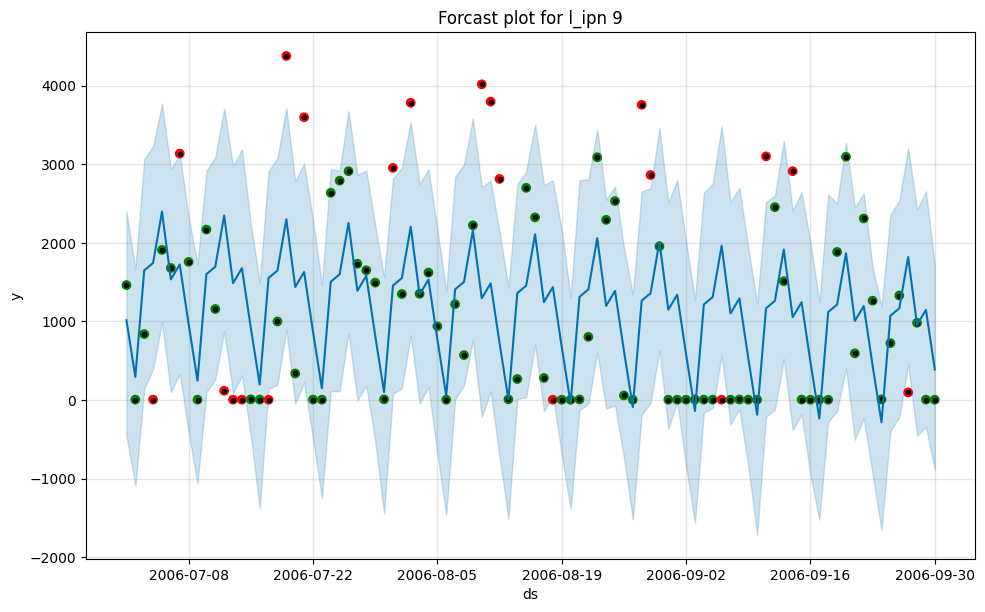

In [ ]:
for i in range(data['l_ipn'].nunique()):
    get_forecast(get_daily_aggregate_l_ipn(i),i)

### b. Using luminol:

In [ ]:
!pip install luminol

In [ ]:
import luminol
from luminol.anomaly_detector import AnomalyDetector

In [ ]:
def get_luminol_anomalies(in_df):
    in_df['isAnomaly'] = 0
    detector = AnomalyDetector(in_df['y'].to_dict())
    anomalies = detector.get_anomalies()
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            in_df.at[k,'isAnomaly'] = 1     
    return(in_df)    

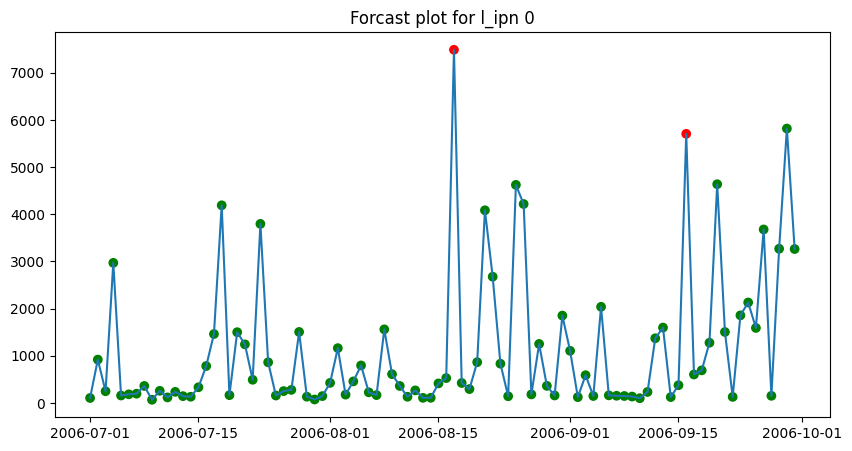

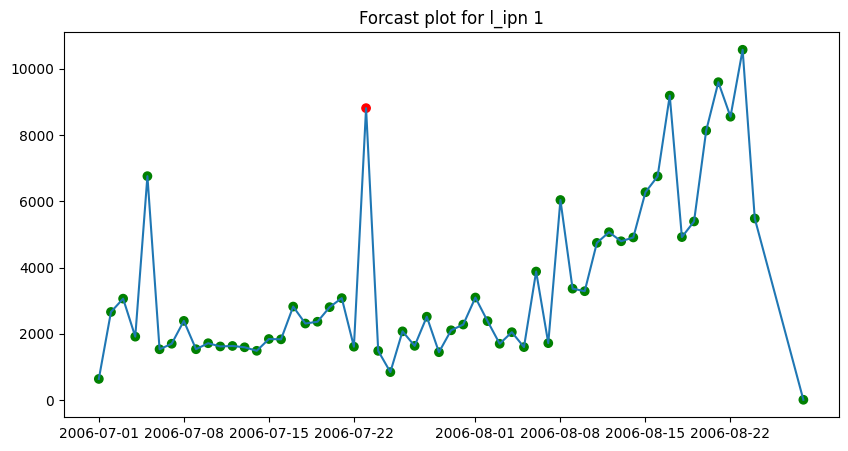

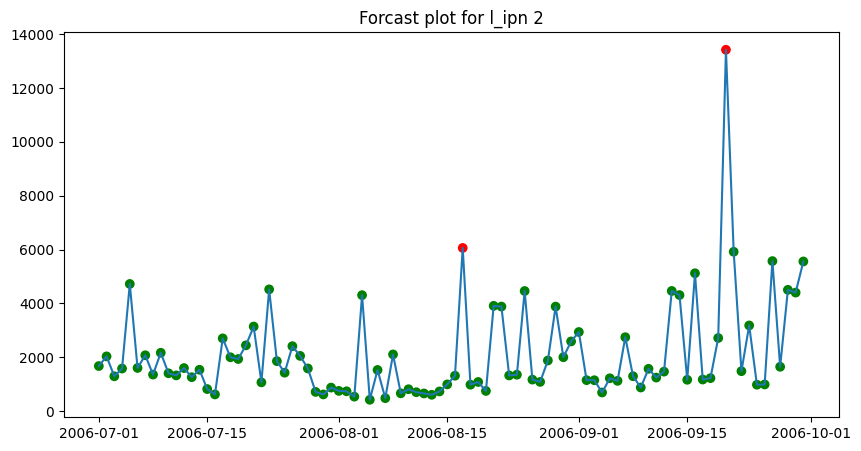

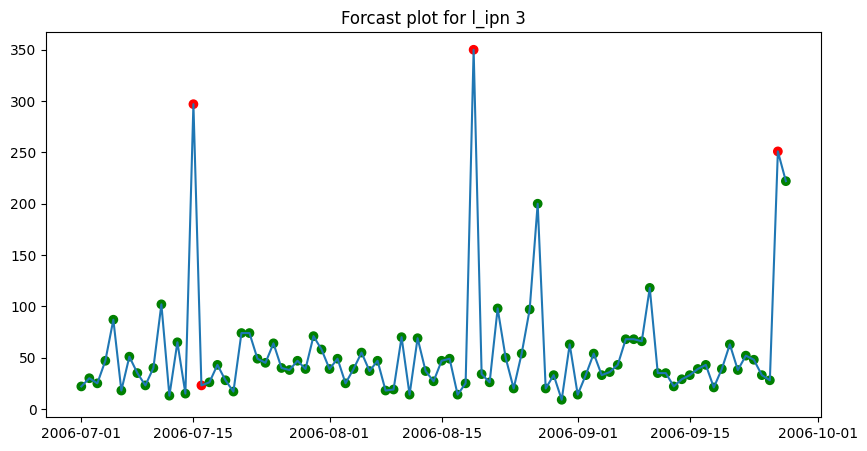

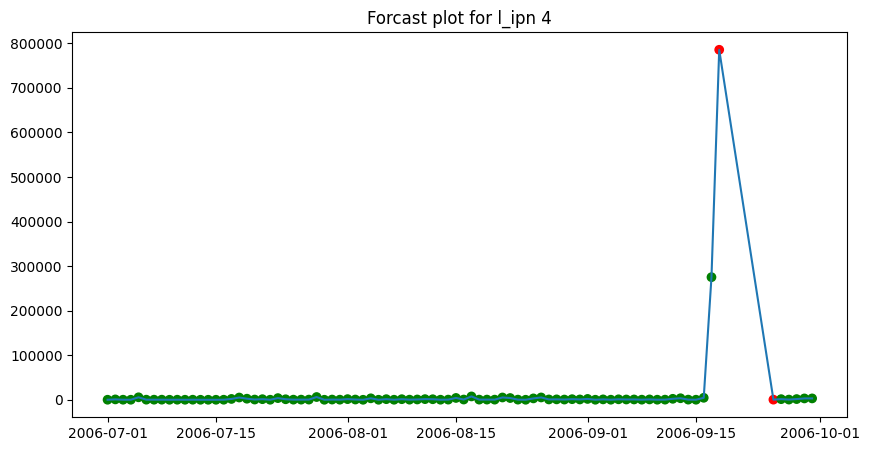

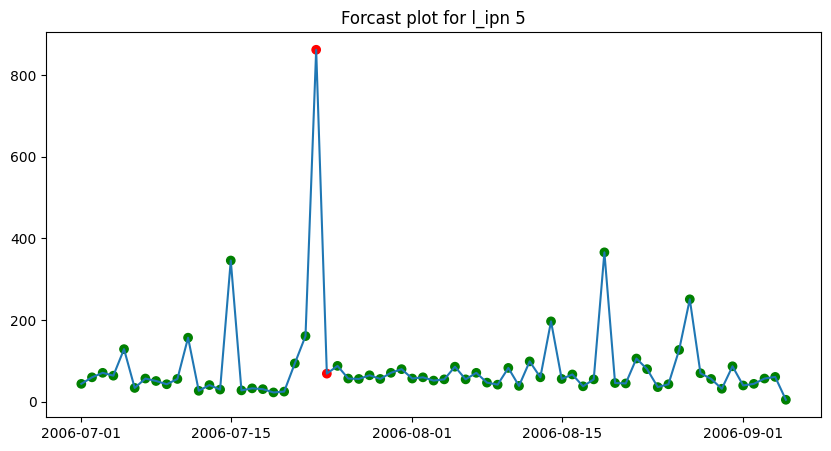

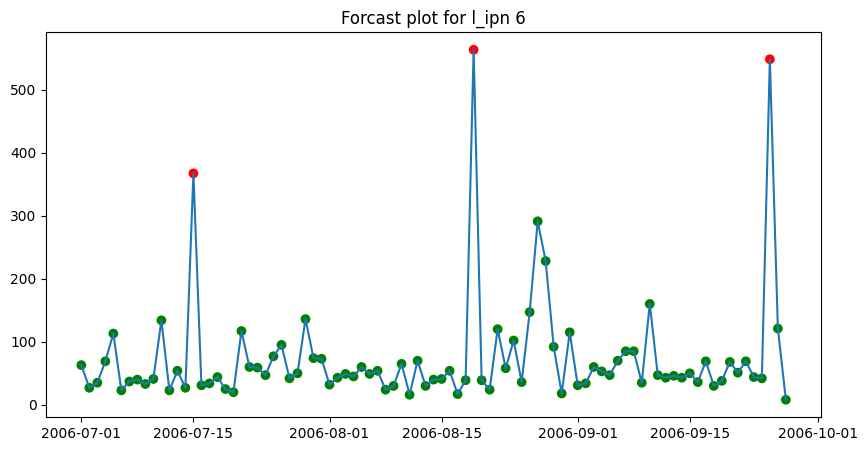

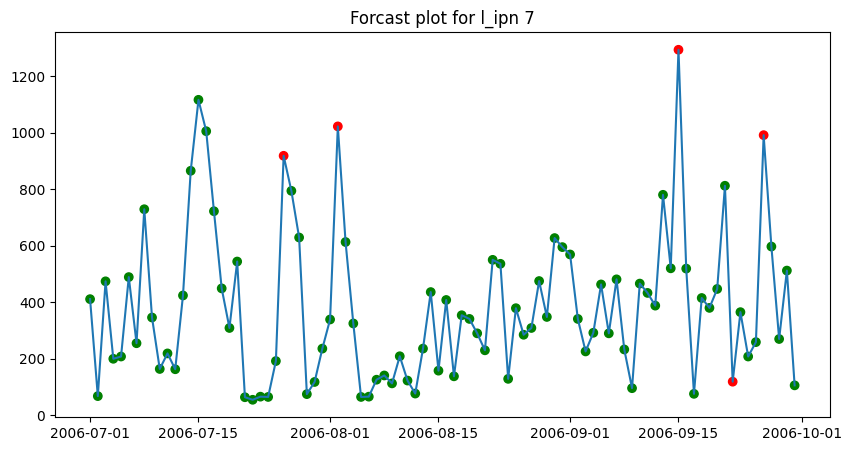

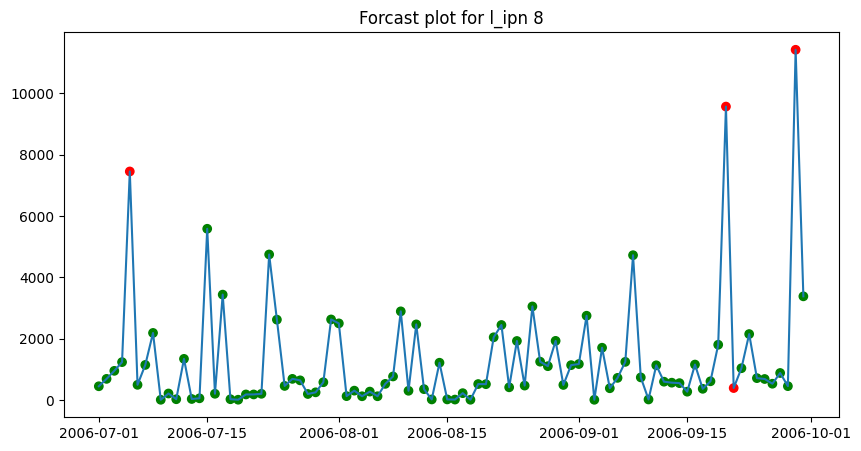

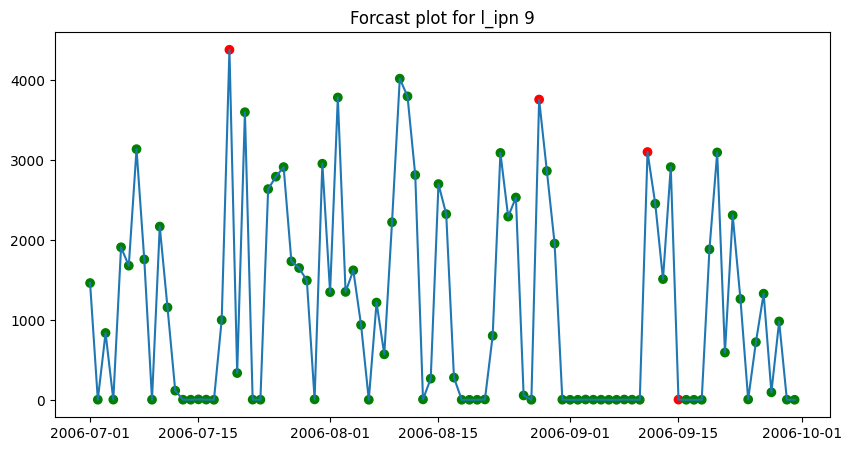

In [ ]:
for i in range(data['l_ipn'].nunique()):
    t_df = get_luminol_anomalies(get_daily_aggregate_l_ipn(i))
    
    colors = {0:'green', 1:'red'}
   
    plt.figure(figsize=(10,5))
    plt.plot(t_df['ds'],t_df['y'])
    plt.scatter(t_df['ds'],t_df['y'],c=t_df['isAnomaly'].apply(lambda x: colors[x]))
    plt.title('Forcast plot for l_ipn %d' %i)
    plt.show()